# Mac and Linux setup

Make sure to have enabled the environment set up for running `dimelo` analysis. See the readme for details. If you are running your jupyter notebook some way other than by the `jupyter notebook` command in the command line from within your activated `conda` environment, you may need to use `ipykernel` to connect this notebook appropriately to the environment with `dimelo` and `modkit` installed.

# Colab setup

If you are running in Google Colab, run the cells below. **It is expected that Colab will make you restart your runtime to enable new package versions.** 

In [1]:
# Lets Colab access your Google drive
try:
    from google.colab import drive
except:
    print("""
You don't seem to be running on Google Colab so this cell is not going to be useful for you.
Make sure you are running you notebook in a conda environment set up as per README.md.
Once you have this notebook running in a correctly configured environment, proceed to the rest of the cells.
          """)
else:
    drive.mount('/content/drive')
    # Install condacolab to let us get the modkit dependency
    !pip install -q condacolab
    import condacolab
    condacolab.install()
    # Install modkit
    !conda install nanoporetech::modkit==0.2.4
    # Clone the repo, change the active path to be inside the repo, and install the package
    !rm -r dimelo_v2
    !git clone https://github.com/streetslab/dimelo_v2
    import os
    os.chdir('dimelo_v2')
    !pip install ipywidgets==7.7.1 .



You don't seem to be running on Google Colab so this cell is not going to be useful for you.
Make sure you are running you notebook in a conda environment set up as per README.md.
Once you have this notebook running in a correctly configured environment, proceed to the rest of the cells.
          


After runtime restart in previous cell, run this cell to make sure your notebook is set up.

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('dimelo_v2')   
except:
    pass

# System and Versions Information

## Conda Environment

Run this cell to list the packages present in your conda environment

In [3]:
!conda list

# packages in environment at /Users/oberondixon-luinenburg/mambaforge/envs/dimelo_v2:
#
# Name                    Version                   Build  Channel
anyio                     4.3.0                    pypi_0    pypi
appnope                   0.1.4                    pypi_0    pypi
argon2-cffi               23.1.0                   pypi_0    pypi
argon2-cffi-bindings      21.2.0                   pypi_0    pypi
arrow                     1.3.0                    pypi_0    pypi
asttokens                 2.4.1                    pypi_0    pypi
async-lru                 2.0.4                    pypi_0    pypi
attrs                     23.2.0                   pypi_0    pypi
babel                     2.15.0                   pypi_0    pypi
beautifulsoup4            4.12.3                   pypi_0    pypi
bleach                    6.1.0                    pypi_0    pypi
bzip2                     1.0.8                h93a5062_5    conda-forge
ca-certificates           2024.2.2            

## System Information

Run this cell to list system information about your machine

In [4]:
import platform
print('System:',platform.system())
print('Release:',platform.release())
print('Version:',platform.version())
print('Processor:',platform.processor())

System: Darwin
Release: 21.6.0
Version: Darwin Kernel Version 21.6.0: Sat Jun 18 17:07:22 PDT 2022; root:xnu-8020.140.41~1/RELEASE_ARM64_T6000
Processor: arm


## Git Repo Version

Run this cell to capture the exact repo version you're running, in case we need to debug anything

In [5]:
!git -C . log -1 --format=%H

aa45543270e33a5d4f2c9b50d0da2787d3a3f9ed


# Initialization

In [6]:
from pathlib import Path
from matplotlib import pyplot as plt
import urllib, gzip

In [7]:
# Base input and output directories
test_data_dir = Path('./dimelo/test/data')
output_dir = Path('./dimelo/test/output')

output_dir.mkdir(exist_ok=True)

# Input files
ctcf_bam_file = test_data_dir / 'ctcf_demo.sorted.bam'
ctcf_guppy_bam_file = test_data_dir / 'winnowmap_guppy_merge_subset.updated.bam'
ctcf_target_regions = test_data_dir / 'ctcf_demo_peak.bed'
ctcf_off_target_regions = test_data_dir / 'ctcf_demo_not_peak.bed'

The cell below only needs to run once; if you try to run it with the reference genome already downloaded it will likely just not complete.

In [8]:
ref_genome_url = 'https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.0.fasta.gz'
ref_genome_gz = output_dir / 'chm13.draft_v1.0.fasta.gz'
ref_genome_file = output_dir / 'chm13.draft_v1.0.fasta'
force_redownload = False
if ref_genome_file.exists() and not force_redownload:
    print('Reference genome already present. Set force_redownload=True to if you want to download it again.')
else:
    urllib.request.urlretrieve(ref_genome_url,ref_genome_gz)

    with gzip.open(ref_genome_gz,'rb') as gzip_file:
        with open(ref_genome_file,'wb') as output_file:
            for chunk in gzip_file:
                output_file.write(chunk)

    ref_genome_gz.unlink()
    print("Reference genome downloaded and decompressed.")
# !curl https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.0.fasta.gz -o ./test/output/chm13.draft_v1.0.fasta.gz
# !gunzip ./test/output/chm13.draft_v1.0.fasta.gz

Reference genome already present. Set force_redownload=True to if you want to download it again.


# Basic Use Overview

For details on parameters and functionality breakdown, please read the README sections on **Basic Use**, especially **Parameters and what they mean**.

# Parsing

In [9]:
from dimelo import parse_bam

modkit found with expected version 0.2.4


## Pileup and Update Tags

Attempting to parse a malformed BAM file will raise an error, thanks to input BAM format checking. Passing a bam file that doesn't meet the specifications directly to `modkit` will typically result in an empty ouput file; `modkit` will find no valid base modifications and return all-zero data.

Megalodon and Guppy bam files are considered malformed because they do not meet the latest .bam spec. Some newer basecallers output correctly formatted files without requiring additional processing.

However, `modkit` comes with two tools that can update bam files to meet spec.

In [10]:
try:
    pileup_file, pileup_regions = parse_bam.pileup(
        input_file=ctcf_bam_file,
        output_name='ctcf_demo_pileup_on_target',
        ref_genome=ref_genome_file,
        output_directory=output_dir,
        regions=[ctcf_target_regions,ctcf_off_target_regions],
        motifs=['A,0','CG,0'],
        # parsing can optionally specify mod codes. 
        # The default is Y or a for adenine and m or Z for cytosine, corresponding to methylation
        # motifs = ['A,0,Y','CG,0,Z'], 
        thresh=190,
        window_size=1000,
        # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
        # quiet = True,
        # cleanup = False,
        # log=True,
    )
    print('The code executed successfully.')
except Exception as e:
    print('This is expected to fail. Read the error message below:\n\n')
    print(e)

This is expected to fail. Read the error message below:


Base modification tags are out of spec (Mm and Ml instead of MM and ML). 

Consider using "modkit update-tags dimelo/test/data/ctcf_demo.sorted.bam new_file.bam" in the command line with your conda environment active and then trying with the new file. For megalodon basecalling/modcalling, you may also need to pass "--mode ambiguous.
Be sure to index the resulting .bam file."
If you are confident that your inputs are ok, pass "override_checks=True" to convert to warning and proceed with processing.


To fix this, follow the suggestion from the error and run `modkit update-tags`...

In [11]:
!modkit update-tags \
dimelo/test/data/ctcf_demo.sorted.bam \
dimelo/test/output/ctcf_demo.updated.bam \
--mode ambiguous

> done, 1024 records processed, 0 failed, 0 skipped                             


In [12]:
ctcf_bam_file_updated = output_dir / 'ctcf_demo.updated.bam'

...and reindex the resulting file.

In [13]:
import pysam

pysam.index(str(ctcf_bam_file_updated))

''

Finally, the updated .bam file can be parsed, both for pileup and read extraction:

In [14]:
pileup_file, pileup_regions = parse_bam.pileup(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_pileup_on_target',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    regions=[ctcf_target_regions,ctcf_off_target_regions],
    motifs=['A,0','CG,0'],
    # parsing can optionally specify mod codes. 
    # The default is Y or a for adenine and m or Z for cytosine, corresponding to methylation
    # motifs = ['A,0,Y','CG,0,Z'], 
    thresh=190,
    window_size=1000,
    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)

No specified number of cores requested. 8 available on machine, allocating all.
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


          | Preprocessing   0% | 00:00

          | Processing ctcf_demo.updated.bam   0% | 00:00<?

          |    0%

## Extract

In [15]:
extract_file, extract_regions = parse_bam.extract(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_extract',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    regions=[ctcf_target_regions,ctcf_off_target_regions],
    motifs=['A,0','CG,0'],
    # parsing can optionally specify mod codes. 
    # The default is Y or a for adenine and m or Z for cytosine, corresponding to methylation
    # motifs = ['A,0,Y','CG,0,Z'], 
    thresh=190,
    window_size=1000,
    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)

No specified number of cores requested. 8 available on machine, allocating all.
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


          | Preprocessing   0% | 00:00

          | Processing ctcf_demo.updated.bam   0% | 00:00<?

          |    0%

          | Transferring 963 from reads.A,0.txt into reads.combined_basemods.h5, new size 963   0% | 00:00<?

          | Preprocessing   0% | 00:00

          | Processing ctcf_demo.updated.bam   0% | 00:00<?

          |    0%

          | Transferring 963 from reads.CG,0.txt into reads.combined_basemods.h5, new size 1926   0% | 00:00<?

# Plotting

## Plot Enrichment Profile

In [16]:
from dimelo import plot_enrichment_profile

<Axes: xlabel='pos', ylabel='fraction modified bases'>

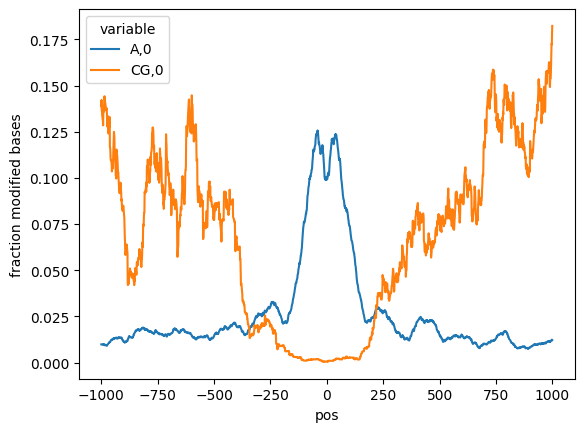

In [17]:
plot_enrichment_profile.by_modification(
    mod_file_name=pileup_file,
    regions=ctcf_target_regions,
    window_size=1000,
    motifs=['A,0','CG,0'],
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    regions_5to3prime=False, # if set to True, regions on the reverse (-) strand will be flipped so everything is 5 prime to 3 prime
    smooth_window=50,
)

<Axes: xlabel='pos', ylabel='fraction modified bases'>

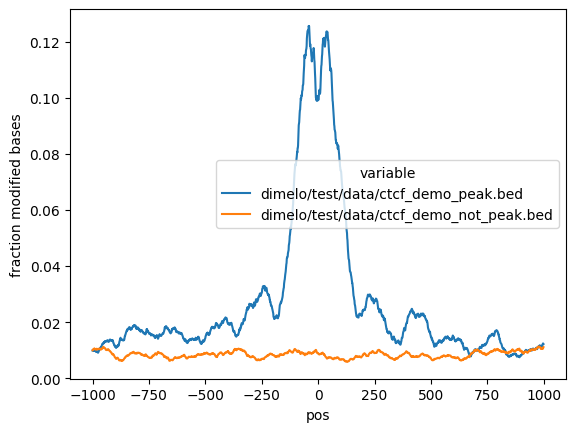

In [18]:
plot_enrichment_profile.by_regions(
    mod_file_name=pileup_file,
    regions_list=[ctcf_target_regions,ctcf_off_target_regions],
    window_size=1000,
    motif='A,0',
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    regions_5to3prime=False, # if set to True, regions on the reverse (-) strand will be flipped so everything is 5 prime to 3 prime
    smooth_window=50
)

## Plot Enrichment

In [19]:
from dimelo import plot_enrichment

<Axes: ylabel='fraction modified bases'>

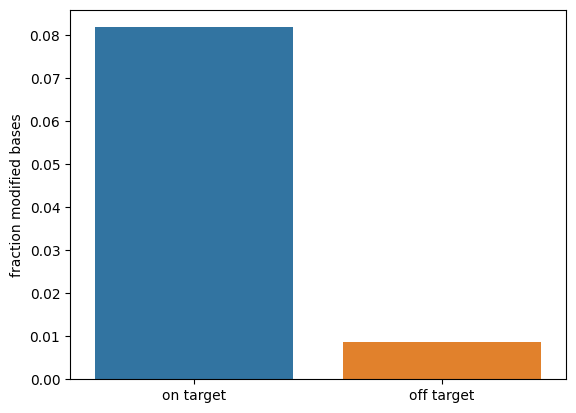

In [20]:
plot_enrichment.by_regions(
    mod_file_name=pileup_file,
    regions_list=[ctcf_target_regions, ctcf_off_target_regions],
    motif='A,0',
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    sample_names=['on target', 'off target']
    )

Text(0.5, 1.0, 'dimelo/test/data/ctcf_demo_peak.bed')

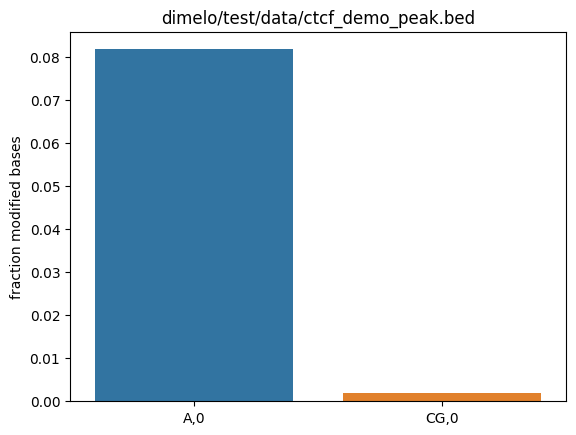

In [21]:
plot_enrichment.by_modification(
    mod_file_name=pileup_file,
    regions=ctcf_target_regions,
    motifs=['A,0','CG,0'],
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    )
plt.title(ctcf_target_regions)

Text(0.5, 1.0, 'dimelo/test/data/ctcf_demo_not_peak.bed')

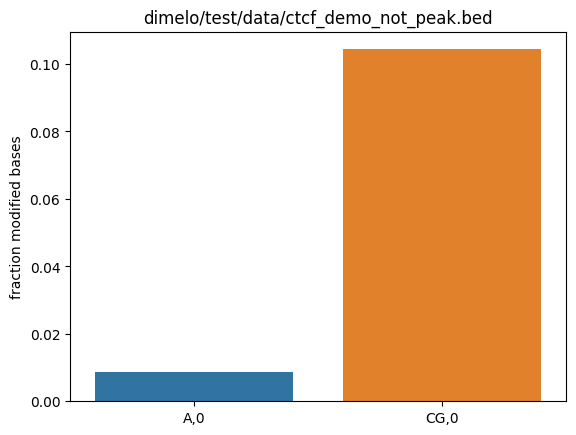

In [22]:
plot_enrichment.by_modification(
    mod_file_name=pileup_file,
    regions=ctcf_off_target_regions,
    motifs=['A,0','CG,0'],
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    )
plt.title(ctcf_off_target_regions)

## Plot Reads

In [23]:
from dimelo import plot_reads

Text(0.5, 1.0, "CTCF target data, 100 known binding locations\nsort_by=['shuffle'] i.e. default")

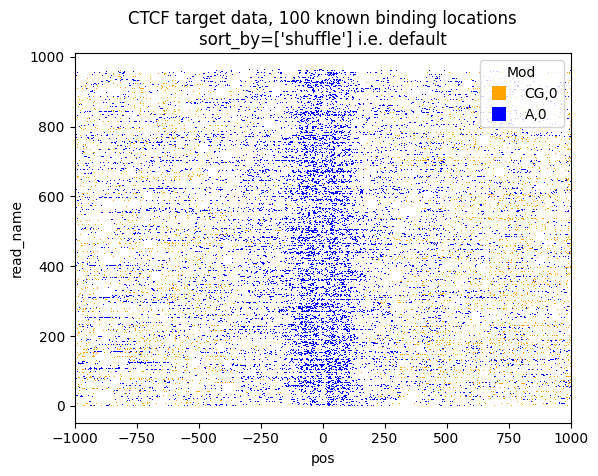

In [24]:
plot_reads.plot_reads(
    mod_file_name=extract_file,
    regions=ctcf_target_regions,
    motifs=['A,0', 'CG,0'],
    window_size=1000,
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    regions_5to3prime=False, # if set to True, regions on the reverse (-) strand will be flipped so everything is 5 prime to 3 prime
)
plt.title("CTCF target data, 100 known binding locations\nsort_by=['shuffle'] i.e. default")

# Advanced Use Cases

## Single Read with Probabilities

The `pileup` operation by definition requires a threshold, but single read extraction can be run with *either* binary modification calls *or* raw probabilities. Run the cell below to re-extract the single reads but with raw base modification probabilities.

In [25]:
extract_file_no_thresh, _ = parse_bam.extract(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_extract_no_thresh',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    regions=[ctcf_target_regions,ctcf_off_target_regions],
    motifs=['A,0','CG,0'],
    # parsing can optionally specify mod codes. 
    # The default is Y or a for adenine and m or Z for cytosine, corresponding to methylation
    # motifs = ['A,0,Y','CG,0,Z'], 
    # thresh=190,
    window_size=1000,
    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)

No specified number of cores requested. 8 available on machine, allocating all.
No valid base modification threshold provided. Raw probs will be saved.


          | Preprocessing   0% | 00:00

          | Processing ctcf_demo.updated.bam   0% | 00:00<?

          |    0%

          | Transferring 963 from reads.A,0.txt into reads.combined_basemods.h5, new size 963   0% | 00:00<?

          | Preprocessing   0% | 00:00

          | Processing ctcf_demo.updated.bam   0% | 00:00<?

          |    0%

          | Transferring 963 from reads.CG,0.txt into reads.combined_basemods.h5, new size 1926   0% | 00:00<?

You can still plot .h5 single read files with our `plot_reads` module, but because no threshold was applied in parsing a threshold must be provided to the plotting module.

In [26]:
try:
    plot_reads.plot_reads(
        mod_file_name=extract_file_no_thresh, # the no threshold file
        regions=ctcf_target_regions, # same regions as before
        motifs=['A,0', 'CG,0'],
        window_size=1000,
    )
except Exception as e:
    print('This is expected to fail. Read the error message below:\n\n')
    print(e)

This is expected to fail. Read the error message below:


No threshold has been applied to this .h5 single read data. You must provide a threshold using the thresh parameter in order to extract binarized modification arrays.


Text(0.5, 1.0, "CTCF target data, 100 known binding locations\nsort_by=['strand', 'A,0_mod_fraction']")

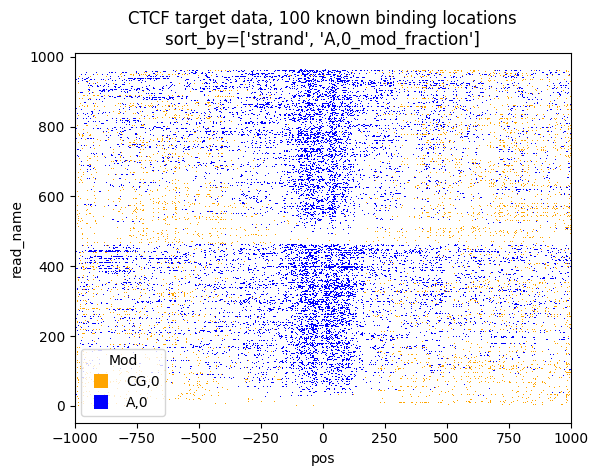

In [27]:
sort_by = ['strand','A,0_mod_fraction'] # you can sort reads also!
plot_reads.plot_reads(
    mod_file_name=extract_file_no_thresh,
    regions=ctcf_target_regions,
    motifs=['A,0', 'CG,0'],
    window_size=1000,
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    regions_5to3prime=False, # if set to True, regions on the reverse (-) strand will be flipped so everything is 5 prime to 3 prime
    thresh=190,
    sort_by=sort_by 
)
plt.title(f'CTCF target data, 100 known binding locations\nsort_by={sort_by}')

## Manually Loading Processed Data

### Load sum total modified/valid base read counts by genomic regions

In [28]:
from dimelo import load_processed

In [29]:
modified_base_count,valid_base_count = load_processed.pileup_counts_from_bedmethyl(
    bedmethyl_file = pileup_file,
    motif = 'A,0',
    regions = ctcf_target_regions,
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
)
print('total methylated adenines across regions in bed file:',modified_base_count,'\ntotal adenine reads called as methylated or unmethylated across regions in bed file:',valid_base_count)

total methylated adenines across regions in bed file: 14242 
total adenine reads called as methylated or unmethylated across regions in bed file: 174078


In [30]:
modified_base_count,valid_base_count = load_processed.pileup_counts_from_bedmethyl(
    bedmethyl_file = pileup_file,
    motif = 'A,0',
    regions = 'chr1:114358436-114358754',
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
)
print('total methylated adenines in single window:',modified_base_count,'\ntotal adenine reads called as methylated or unmethylated in single window:',valid_base_count)

total methylated adenines in single window: 213 
total adenine reads called as methylated or unmethylated in single window: 1619


### Load pileup vectors (modified and valid base read counts) aligned to target region(s)

In [31]:
modified_base_counts,valid_base_counts = load_processed.pileup_vectors_from_bedmethyl(
    bedmethyl_file = pileup_file,
    motif = 'A,0',
    regions = ctcf_target_regions, # Regions from bed file
    window_size = 10, # Trim/extend regions to same size
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    regions_5to3prime=False, # if set to True, regions on the reverse (-) strand will be flipped so everything is 5 prime to 3 prime
)
print('methylated adenines by position near peak center:\n',modified_base_counts,'\nadenine reads by position, called as methylated or unmethylated:\n',valid_base_counts)

methylated adenines by position near peak center:
 [38 53 32  6  4 54  2 83 90  0 85 39 15 45 11 18 11 16 38 20] 
adenine reads by position, called as methylated or unmethylated:
 [588 679 297 210  70 534  58 445 839   0 891 431  80 486  51 303 286 514
 491 589]


In [32]:
modified_base_counts,valid_base_counts = load_processed.pileup_vectors_from_bedmethyl(
    bedmethyl_file = pileup_file,
    motif = 'A,0',
    regions = 'chr1:114358585-114358605', # Region from string specifier
    window_size = None, # No adjustment applied to regions 
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    regions_5to3prime=False, # if set to True, regions on the reverse (-) strand will be flipped so everything is 5 prime to 3 prime
)
print('methylated adenines by position near peak center:\n',modified_base_counts,'\nadenine reads by position, called as methylated or unmethylated:\n',valid_base_counts)

methylated adenines by position near peak center:
 [1 0 3 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0] 
adenine reads by position, called as methylated or unmethylated:
 [14  0 14  0  0 13 14 14 13  0 13  0  0  0  0  0  0  0 13  0]


### Load modified/valid base information by individual reads

In [33]:
read_data_list, datasets, _ = load_processed.read_vectors_from_hdf5(
    file=extract_file, # binarized modification calls
    regions=ctcf_target_regions,
    motifs=['CG,0','A,0'],
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    sort_by = ['chromosome','read_start','read_name']
)
# Print out the data from the first read
for idx,dataset in enumerate(datasets):
    print(dataset)
    for read_data in read_data_list:
        print('\t'+str(read_data[idx]))
        break

chromosome
	chr1
mod_vector
	[False False False ... False False False]
motif
	A,0
read_end
	9206582
read_name
	bc8057e5-935b-4a1a-a0de-f7a4c0dbe4bb
read_start
	9127032
strand
	-
val_vector
	[False False False ... False False  True]
region_start
	9169918
region_end
	9170236
region_strand
	+
CG,0_mod_fraction
	0.15053763440860216
A,0_mod_fraction
	0.01842948717948718


In [34]:
read_data_list, datasets, _ = load_processed.read_vectors_from_hdf5(
    file=extract_file_no_thresh, # raw modification probabilities
    regions=ctcf_target_regions,
    motifs=['CG,0','A,0'],
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
)
# Print out the data from the first read
for idx,dataset in enumerate(datasets):
    print(dataset)
    for read_data in read_data_list:
        print('\t',read_data[idx])
        break

chromosome
	 chr1
mod_vector
	 [0.       0.       0.       ... 0.       0.       0.001953]
motif
	 A,0
read_end
	 9206582
read_name
	 bc8057e5-935b-4a1a-a0de-f7a4c0dbe4bb
read_start
	 9127032
strand
	 -
val_vector
	 [0 0 0 ... 0 0 1]
region_start
	 9169918
region_end
	 9170236
region_strand
	 +
CG,0_mod_fraction
	 0.19119623655913978
A,0_mod_fraction
	 0.05000500801282051


# Mod code specification and adjustment

In addition to the modification context motif and mod quality threshold, the `dimelo` package can delineate different modification codes. For example, a cytosine called with Dorado on Nanopore R10 traces can have modification scores reported for both `m` (methylation) and `h` (hydroxymethylation). These have different biological relevance and may be important to distinguish.

By default, the `dimelo` package only looks for methylation. However, the `motif` specifier can optionally include a third field, e.g. `CG,0,m` or `CG,0,h' to call out a specific mod code.

Different base callers may use different mod codes however. For example, Guppy and Megalodon for R9 Nanopore data tend to us `Y` for adenine and `Z` for cytosine, while the standard is `a` and `m`.

The `dimelo` package reports a warning if a specific mod code is not present, and the bundled `modkit` program offers a command line tool to make adjustments to bam files as desired.

In [35]:
pileup_file_coded, pileup_regions = parse_bam.pileup(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_pileup_on_target_mod_code_specified',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    regions=[ctcf_target_regions,ctcf_off_target_regions],
    # motifs=['A,0','CG,0'],
    # parsing can optionally specify mod codes. 
    # The default is Y or a for adenine and m or Z for cytosine, corresponding to methylation
    motifs = ['A,0,a','CG,0,m'], 
    thresh=190,
    window_size=1000,
    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)


Do you expect this file to contain these modifications? parse_bam is looking for ['A,0,a', 'CG,0,m'] but for ['A', 'C'] found only found ["A+{'Y'}", "C+{'Z'}"].

Consider passing only the motifs and mod codes (e.g. m,h,a) that you expect to be present in your file. 
You can use modkit adjust-mods --convert <CONVERT> <CONVERT> [OPTIONS] <IN_BAM> <OUT_BAM> to update or consolidate mod codes.
See https://github.com/nanoporetech/modkit/blob/master/book/src/advanced_usage.md
                    
No specified number of cores requested. 8 available on machine, allocating all.
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


          | Preprocessing   0% | 00:00

          | Processing ctcf_demo.updated.bam   0% | 00:00<?

          |    0%

`dimelo` lets you run even if the mod codes aren't found in the first 100 reads, but the warning is worth paying attention to: sometimes, as in this case, they actually aren't present at all!

In that case, plotting will yield an empty plot. We clearly need to properly specify the mod codes if we want the right result.

<Axes: xlabel='pos', ylabel='fraction modified bases'>

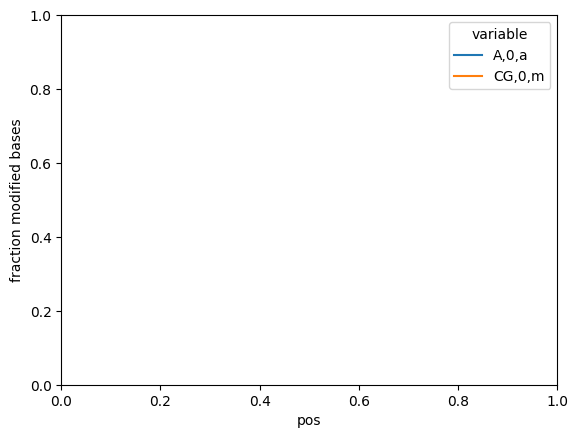

In [36]:
from dimelo import plot_enrichment_profile
plot_enrichment_profile.by_modification(
    mod_file_name=pileup_file_coded,
    regions=ctcf_target_regions,
    window_size=1000,
    motifs=['A,0,a','CG,0,m'], # We know from above that these mod codes aren't present in our file!
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    regions_5to3prime=False, # if set to True, regions on the reverse (-) strand will be flipped so everything is 5 prime to 3 prime
    smooth_window=50,
)

The `modkit` command below will make the bam file work for the to-spec mod codes m and a. However, you must use this command with caution: `modkit` can and will adjust any mod code to any other mod code; you need to verify yourself that they are actually equivalent and thus that the operation is in fact valid.

In [37]:
!modkit adjust-mods dimelo/test/output/ctcf_demo.updated.bam dimelo/test/output/ctcf_demo.recoded.bam --convert Y a --convert Z m

> Converting Y to a
> Converting Z to m
> done, 1025 records processed, 0 failed, 0 skipped                                      


In [38]:
ctcf_bam_file_recoded = output_dir / 'ctcf_demo.recoded.bam'
pysam.index(str(ctcf_bam_file_recoded))

''

In [39]:
pileup_file_recoded, pileup_regions = parse_bam.pileup(
    input_file=ctcf_bam_file_recoded,
    output_name='ctcf_demo_pileup_on_target_mod_code_specified_adjusted',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    regions=[ctcf_target_regions,ctcf_off_target_regions],
    # motifs=['A,0','CG,0'],
    # parsing can optionally specify mod codes. 
    # The default is Y or a for adenine and m or Z for cytosine, corresponding to methylation
    motifs = ['A,0,a','CG,0,m'], 
    thresh=190,
    window_size=1000,
    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)

No specified number of cores requested. 8 available on machine, allocating all.
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


          | Preprocessing   0% | 00:00

          | Processing ctcf_demo.recoded.bam   0% | 00:00<?

          |    0%

<Axes: xlabel='pos', ylabel='fraction modified bases'>

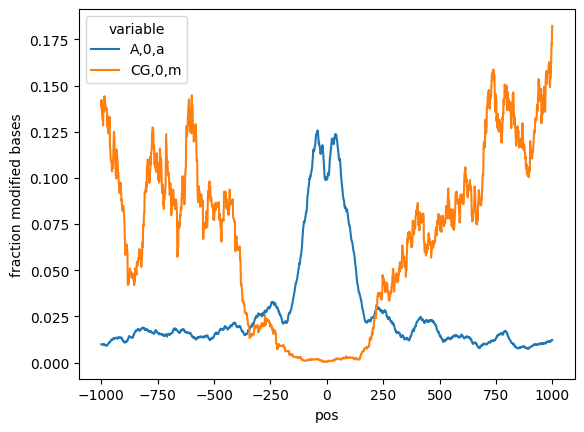

In [40]:
from dimelo import plot_enrichment_profile
plot_enrichment_profile.by_modification(
    mod_file_name=pileup_file_recoded,
    regions=ctcf_target_regions,
    window_size=1000,
    motifs=['A,0,a','CG,0,m'],
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    regions_5to3prime=False, # if set to True, regions on the reverse (-) strand will be flipped so everything is 5 prime to 3 prime
    smooth_window=50,
)